In [1]:
import numpy as np
import pandas as pd
from model.autoencoder import AutoEncoder
from model.vae import VAE
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

In [2]:
pd_atac = pd.read_csv('./data/expr_atac_processed.csv', index_col=0)
pd_rna = pd.read_csv('./data/expr_rna_processed.csv', index_col=0)
atac = pd_atac.to_numpy()
rna = pd_rna.to_numpy()

In [21]:
def pairwise_distances(x):
    x_norm = (x**2).sum(1).view(-1, 1)
    y = x
    y_norm = x_norm.view(1, -1)

    dist = x_norm + y_norm - 2.0 * torch.mm(x, torch.transpose(y, 0, 1))
    return dist 

In [23]:
def loss(recon_atac, recon_rna, atac, rna, z, diff_distance, lamb):
    loss = F.mse_loss(rna, recon_rna) + F.mse_loss(atac, recon_atac) + lamb * F.mse_loss(diff_distance.reshape(-1), pairwise_distances(x).reshape(-1))
    return loss

In [31]:
class scDataset(Dataset):

    def __init__(self, atac_seq_file = "./data/expr_atac_processed.csv", rna_seq_file = "./data/expr_rna_processed.csv", standardize = False):
        self.expr_ATAC = pd.read_csv(atac_seq_file, index_col=0).to_numpy()
        self.expr_RNA = pd.read_csv(rna_seq_file, index_col=0).to_numpy()
        # standardize
        if standardize:
            self.expr_ATAC = StandardScaler().fit_transform(self.expr_ATAC)
            self.expr_RNA = StandardScaler().fit_transform(self.expr_RNA)

        # self.transform = transform
    
    def __len__(self):
        # number of cells
        return len(self.expr_ATAC)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # index denote the index of the cell
        sample = {'ATAC': self.expr_ATAC[idx,:], 'RNA':self.expr_RNA[idx,:], 'index':idx}
        
        # if self.transform:
        #     sample = self.transform(sample)
        
        return sample

# # transform
# class standardize(object):

#     def __call__(self, sample):
#         sample_ATAC = StandardScaler().fit_transform(sample['ATAC'][None,:])
#         sample_RNA = StandardScaler().fit_transform(sample['RNA'][None,:])
#         return {'ATAC': torch.from_numpy(sample_ATAC.squeeze()), 'RNA':torch.from_numpy(sample_RNA.squeeze())}

In [32]:
sc_dataset = scDataset(standardize = True)
data_loader = DataLoader(sc_dataset, batch_size=4, shuffle=True, num_workers=0)

In [33]:
for idx, data in enumerate(data_loader):
    data
    break

In [34]:
data['RNA'].shape

torch.Size([4, 1185])

In [35]:
data

{'ATAC': tensor([[-0.0412, -0.0582, -0.0491,  ..., -0.0845, -0.0458, -0.0634],
         [-0.0412, -0.0582, -0.0491,  ..., -0.0845, -0.0458, -0.0634],
         [-0.0412, -0.0582, -0.0491,  ..., -0.0845, 20.5111, -0.0634],
         [-0.0412, -0.0582, -0.0491,  ..., -0.0845, -0.0458, -0.0634]],
        dtype=torch.float64),
 'RNA': tensor([[-0.2093,  0.9976, -0.8166,  ...,  2.3138,  0.8202,  4.3546],
         [-0.2093, -0.4197,  0.5704,  ..., -0.3284, -0.5554, -0.3166],
         [-0.2093, -0.4197,  1.0574,  ..., -0.3284, -0.5554, -0.3166],
         [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166]],
        dtype=torch.float64),
 'index': tensor([ 518, 1883, 1095, 1894])}

## Diffusion distance

In [3]:
import numpy as np
from sklearn import datasets
import diffusion_dist as diff
import matplotlib.pyplot as plt
N = 1000
X, color = datasets.make_s_curve(N, random_state=0)

In [4]:
diffu = diff.diffusion_map(X, n_eign = 10, alpha = 0.009, diffusion_time = 5)
diff_sim = diff.diffusion_similarity(diffu)

**First two dimensions of the diffusion distance**

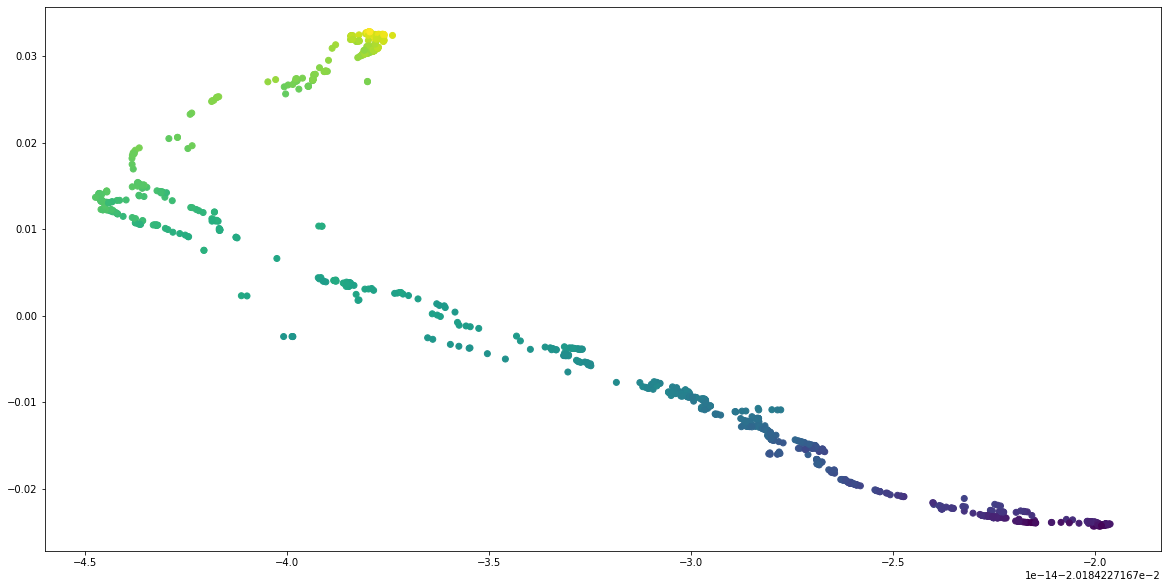

In [5]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(diffu[:,0], diffu[:,1], c = color)

**Original distance**

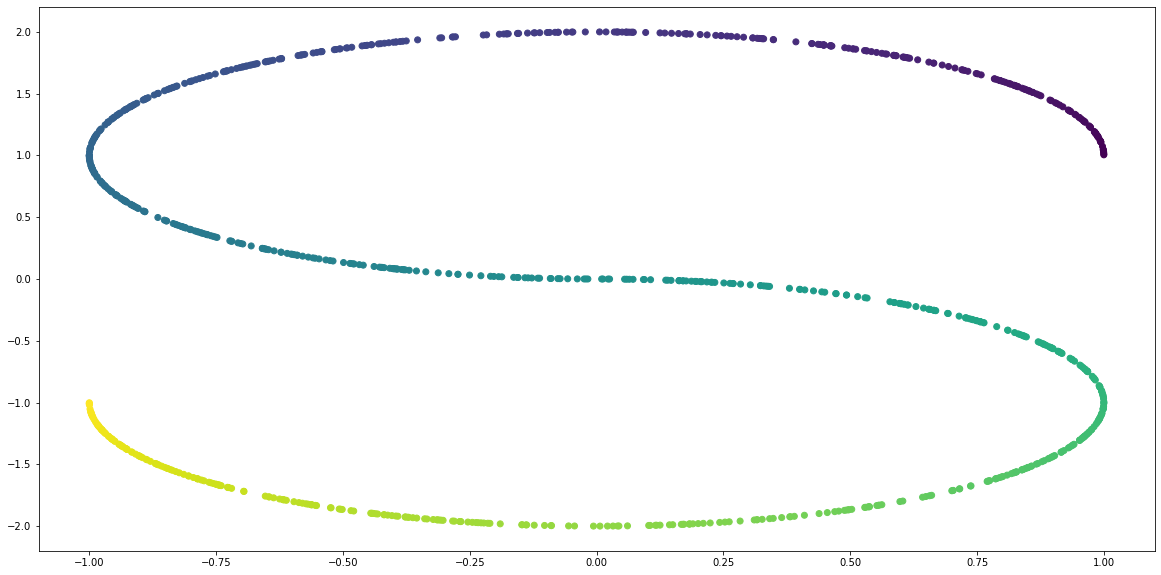

In [6]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(X[:,0], X[:,2], c= color)

**Diffusion distance similarity matrix**

In [9]:
diff_sim.shape

(1000, 1000)

In [20]:
def latent_semantic_indexing(doc_matrix):
    """\
        Compute LSI, i.e. SVD on document matrix

        Parameters:
            doc_matrix: term by document count matrix
        Returns:
            latent: document latent matrix
    """
    from scipy.linalg import svd
    U, S, Vh = svd(doc_matrix, full_matrices = False, compute_uv = True)
    latent = np.matmul(Vh.T, np.diag(S)) 
    return latent

In [21]:
doc_matrix = np.random.randn(3,5)
doc_latent = latent_semantic_indexing(doc_matrix)

In [22]:
doc_latent.shape

(5, 3)